In [1]:
from mnist import load_mnist

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np

# Pytorch에서도 전체적인 과정은 똑같습니다. 
## 다만, 클래스안에는 네트워크 구조와 forward propagation에 대해서만 정의합니다.

<span style = 'font-size:1.2em;line-height:1.5em'>다음과 같은 과정을 수행해야 합니다.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>1. neural network class 정의하기: 여기선, Two-layer FFNN을 정의하겠습니다.이 클래스에는 다음과 같은 속성과 메소드가 필요합니다.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(1)params 속성: </b>Network의 weight들이 들어있는 dictionary.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(2)predict() 메소드: </b>Forward Propagation을 진행하는 메소드</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(3)get_loss() 메소드: </b>predict()의 결과와 실제 레이블을 비교하여 cross entropy loss를 계산하는 메소드</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(4)get_grad() 메소드: </b>현재 W상태에서 gradient를 산출하는 메소드</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(5)get_accuracy() 메소드: </b>(Optional) 현재 상태에서 네트워크가 inference하는 결과의 정확도를 산출하는 메소드</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>2. Mini-batch 데이터를 데이터에 입력</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>3. 현재 W상태에서 gradient를 계산</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>4. gradient descent로 learning_rate만큼 이동</span>

In [3]:
nn.LogSoftmax

torch.nn.modules.activation.LogSoftmax

In [4]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(784,100)
        self.fc2 = nn.Linear(100,10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        result = F.log_softmax(x, dim=1)
        return result

In [5]:
# CPU? GPU?
if torch.cuda.is_available(): # GPU쓸수 있으면
    device = torch.device("cuda:0") #GPU로 할게요
else: # 안되면
    device = torch.device("cpu:0") #CPU 쓸게요

In [6]:
device

device(type='cpu', index=0)

In [7]:
batch_size = 256
lr = 2e-4

In [8]:
# 데이터의 다운, 변환, batch_data_generator를 생성
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), 
                                                   (0.3081,))
                             ])

dataset1 = datasets.MNIST('data_torch', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('data_torch', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, 
                                           shuffle=True, 
                                           batch_size=batch_size, 
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset2, 
                                          shuffle=False, 
                                          batch_size=batch_size, 
                                          drop_last=False)

### 모델을 생성하고, 이 모델을 GPU상에서 사용할지, CPU에서 사용할지 결정

In [9]:
dataset1.data.shape[0]

60000

In [10]:
model = MyNet().to(device)

In [11]:
optimizer = optim.SGD(model.parameters(), lr=lr) # model.parameters() -> 모든 파라미터 업데이트 

In [12]:
# for param in model.parameters():
#     print(param)

### 자, 모델을 학습해봅시다

In [13]:
%%time
for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(-1,784).to(device), target.to(device) # 4차원 -> 2차원 변환
        optimizer.zero_grad() # gradient를 계산 할때마다 해줘야함
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(-1,784).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 0 [25344/60000 (42%)]	Loss: 2.286676
Train Epoch: 0 [50944/60000 (85%)]	Loss: 2.281361

Test set: Average loss: 2.2448, Accuracy: 1685/10000 (17%)

Train Epoch: 1 [25344/60000 (42%)]	Loss: 2.225386
Train Epoch: 1 [50944/60000 (85%)]	Loss: 2.180018

Test set: Average loss: 2.1730, Accuracy: 2879/10000 (29%)

Train Epoch: 2 [25344/60000 (42%)]	Loss: 2.124023
Train Epoch: 2 [50944/60000 (85%)]	Loss: 2.106982

Test set: Average loss: 2.1017, Accuracy: 4128/10000 (41%)

Train Epoch: 3 [25344/60000 (42%)]	Loss: 2.067292
Train Epoch: 3 [50944/60000 (85%)]	Loss: 2.031705

Test set: Average loss: 2.0297, Accuracy: 5021/10000 (50%)

Train Epoch: 4 [25344/60000 (42%)]	Loss: 2.009344
Train Epoch: 4 [50944/60000 (85%)]	Loss: 1.963828

Test set: Average loss: 1.9563, Accuracy: 5629/10000 (56%)

Train Epoch: 5 [25344/60000 (42%)]	Loss: 1.944550
Train Epoch: 5 [50944/60000 (85%)]	Loss: 1.903793

Test set: Average loss: 1.8814, Accuracy: 6107/10000 (61%)

Train Epoch: 6 [25344/60000 (42%)]

# 연습문제

<span style = 'font-size:1.2em;line-height:1.5em'>1. 똑같은 코드를 colab에서 돌려볼까요? GPU를 사용해서 돌려보시고, 실행 속도 차이가 얼마나 나는지 확인해보세요</span>

In [14]:
device = torch.device('mps') if torch.backends.mps.is_available() else 'cpu'
device

device(type='mps')

In [15]:
model_gpu = MyNet().to(device)

In [16]:
optimizer_gpu = optim.SGD(model_gpu.parameters(), lr=lr) # model.parameters() -> 모든 파라미터 업데이트 

In [17]:
%%time

print('device: ', device)

for epoch in range(10):
    model_gpu.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(-1,784).to(device), target.to(device) # 4차원 -> 2차원 변환
        optimizer_gpu.zero_grad() # gradient를 계산 할때마다 해줘야함
        output = model_gpu(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer_gpu.step()
        if (batch_idx+1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    model_gpu.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(-1,784).to(device), target.to(device)
            output = model_gpu(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

device:  mps
Train Epoch: 0 [25344/60000 (42%)]	Loss: 2.265014
Train Epoch: 0 [50944/60000 (85%)]	Loss: 2.269640

Test set: Average loss: 2.2449, Accuracy: 1655/10000 (17%)

Train Epoch: 1 [25344/60000 (42%)]	Loss: 2.220224
Train Epoch: 1 [50944/60000 (85%)]	Loss: 2.196372

Test set: Average loss: 2.1784, Accuracy: 2890/10000 (29%)

Train Epoch: 2 [25344/60000 (42%)]	Loss: 2.141584
Train Epoch: 2 [50944/60000 (85%)]	Loss: 2.133624

Test set: Average loss: 2.1123, Accuracy: 3887/10000 (39%)

Train Epoch: 3 [25344/60000 (42%)]	Loss: 2.109396
Train Epoch: 3 [50944/60000 (85%)]	Loss: 2.053957

Test set: Average loss: 2.0454, Accuracy: 4668/10000 (47%)

Train Epoch: 4 [25344/60000 (42%)]	Loss: 2.027214
Train Epoch: 4 [50944/60000 (85%)]	Loss: 1.984505

Test set: Average loss: 1.9771, Accuracy: 5373/10000 (54%)

Train Epoch: 5 [25344/60000 (42%)]	Loss: 1.979400
Train Epoch: 5 [50944/60000 (85%)]	Loss: 1.930369

Test set: Average loss: 1.9078, Accuracy: 5917/10000 (59%)

Train Epoch: 6 [25344

<span style = 'font-size:1.2em;line-height:1.5em'>2. Colab상에서 train_loss와 test_loss, test_accurcy를 누적시켜 기록한뒤, matplotlib으로 누적해서 plot해봅시다. 이 때, train_loss는 batch단위로 계산하되, average로 기록하세요</span>

In [18]:
model_plot = MyNet().to(device)

In [19]:
optimizer_plot = optim.SGD(model_plot.parameters(), lr=lr) # model.parameters() -> 모든 파라미터 업데이트 

In [20]:
%%time
print('device: ',device)

train_batch_loss_li = [] # train batch loss 리스트 선언
test_loss_li = [] # test loss 리스트 선언
test_acc_li = [] # test accurucy 리스트 선언

for epoch in range(10):
    model_plot.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(-1,784).to(device), target.to(device)
        optimizer_plot.zero_grad()
        output = model_plot(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer_plot.step()
        if (batch_idx+1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_batch_loss_li.append(loss.item()) 
            
    model_plot.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(-1,784).to(device), target.to(device)
            output = model_plot(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
 
    test_loss /= len(test_loader.dataset)
    test_loss_li.append(test_loss)
    test_acc_li.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

device:  mps
Train Epoch: 0 [25344/60000 (42%)]	Loss: 2.292152
Train Epoch: 0 [50944/60000 (85%)]	Loss: 2.276693

Test set: Average loss: 2.2638, Accuracy: 1208/10000 (12%)

Train Epoch: 1 [25344/60000 (42%)]	Loss: 2.234835
Train Epoch: 1 [50944/60000 (85%)]	Loss: 2.173661

Test set: Average loss: 2.1838, Accuracy: 1904/10000 (19%)

Train Epoch: 2 [25344/60000 (42%)]	Loss: 2.152726
Train Epoch: 2 [50944/60000 (85%)]	Loss: 2.117001

Test set: Average loss: 2.1082, Accuracy: 2994/10000 (30%)

Train Epoch: 3 [25344/60000 (42%)]	Loss: 2.080601
Train Epoch: 3 [50944/60000 (85%)]	Loss: 2.040242

Test set: Average loss: 2.0342, Accuracy: 4190/10000 (42%)

Train Epoch: 4 [25344/60000 (42%)]	Loss: 2.018140
Train Epoch: 4 [50944/60000 (85%)]	Loss: 1.970801

Test set: Average loss: 1.9605, Accuracy: 5061/10000 (51%)

Train Epoch: 5 [25344/60000 (42%)]	Loss: 1.980984
Train Epoch: 5 [50944/60000 (85%)]	Loss: 1.883342

Test set: Average loss: 1.8867, Accuracy: 5683/10000 (57%)

Train Epoch: 6 [25344

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

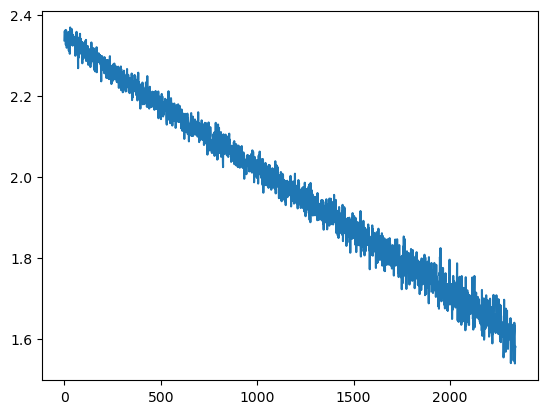

In [22]:
plt.plot(train_batch_loss_li)

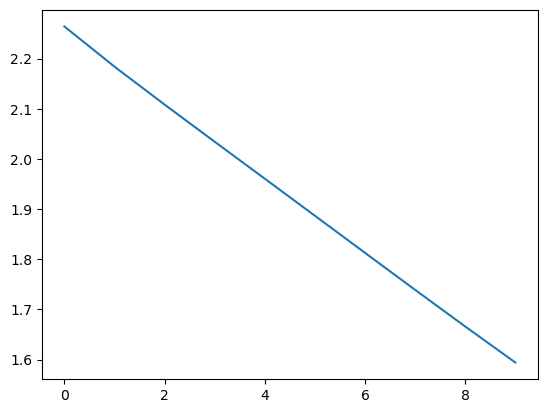

In [23]:
plt.plot(test_loss_li)

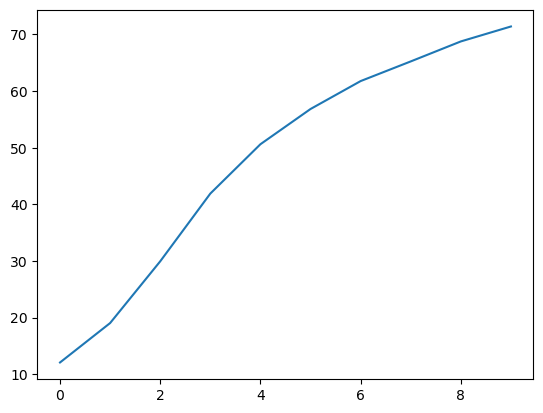

In [24]:
plt.plot(test_acc_li)

# 과제 

<span style = 'font-size:1.2em;line-height:1.5em'>1. 모델 학습이 완료된 뒤, 모델의 예측값과 실제 레이블 값이 다른 데이터를 5개 선택하시고, 어떤 데이터여서 틀린것인지 matplotlib을 활용하여 알아보세요. matplotlib을 사용하여 그리는 방법은 지난주 실습자료에 있으니 참고하세요.</span>

In [25]:
# 실제 레이블 
real_label = dataset2.targets
real_data = dataset2.data

In [26]:
# batch 1로 변경 
test_loader = torch.utils.data.DataLoader(dataset2, 
                                          shuffle=False, 
                                          batch_size=1, 
                                          drop_last=False)

In [32]:
cnt=0

with torch.no_grad():
    for idx, (data, target) in enumerate(test_loader):
        data, target = data.view(-1,784).to(device), target.to(device)
        output = model_plot(data)
        
        pred = output.argmax(dim=1, keepdim=True).flatten()  # get the index of the max log-probability
        
        if cnt == 5:
            break
        elif pred.item() != target.item():
            print(f'idx: {idx}, pred: {pred.item()}, target: {target.item()}')
            cnt += 1

idx: 8, pred: 0, target: 5
idx: 9, pred: 7, target: 9
idx: 11, pred: 0, target: 6
idx: 15, pred: 3, target: 5
idx: 17, pred: 3, target: 7


### 확인

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

tensor(5)


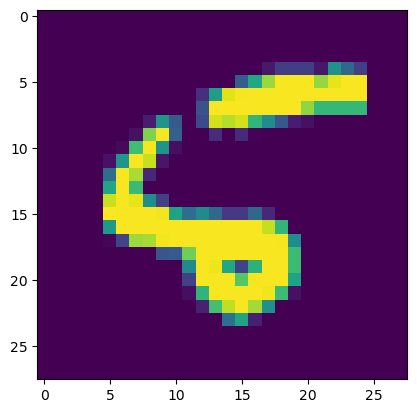

In [36]:
print(real_label[8])
plt.imshow(real_data[8].reshape(28,28))

tensor(9)


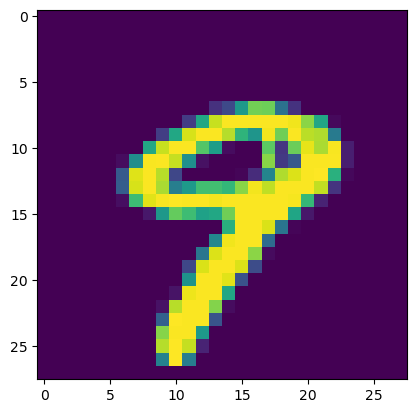

In [39]:
print(real_label[9])
plt.imshow(real_data[9].reshape(28,28))

tensor(6)


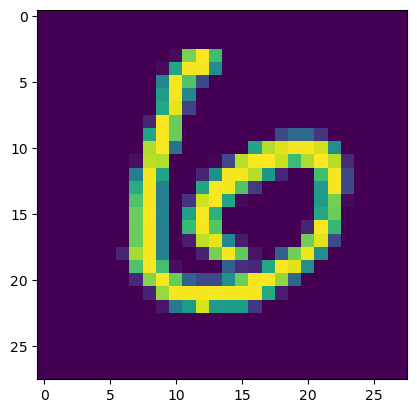

In [38]:
print(real_label[11])
plt.imshow(real_data[11].reshape(28,28))

tensor(5)


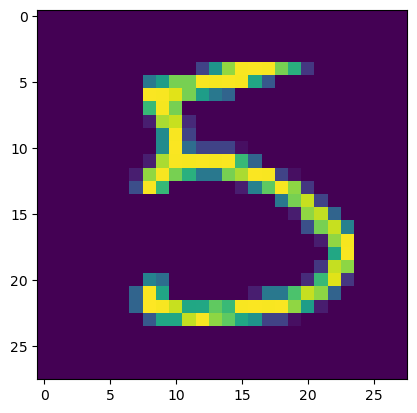

In [40]:
print(real_label[15])
plt.imshow(real_data[15].reshape(28,28))

tensor(7)


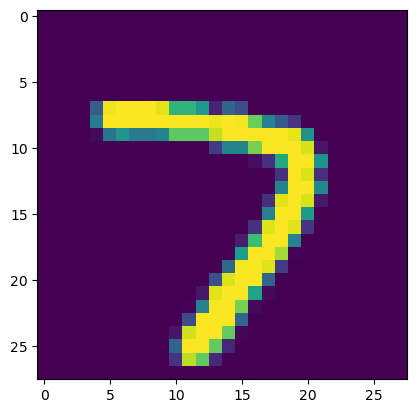

In [41]:
print(real_label[17])
plt.imshow(real_data[17].reshape(28,28))